In [1]:
import itertools
import glob
from collections import defaultdict
from pathlib import Path

import dask.dataframe as dd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from gimmemotifs.motif import Motif, read_motifs
from gimmemotifs.fasta import Fasta
from gimmemotifs.scanner import Scanner
from nopeak_utils.nopeak import NoPeakMotif
from nopeak_utils.scores import ScoreSet
from tfomics import ReferenceGenome

%matplotlib inline

/Users/oalmelid/anaconda3/envs/nopeak_utils/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fontconfig warning: ignoring UTF-8: not a valid region tag


In [2]:
ReferenceGenome.offset = 25
genome = ReferenceGenome("genome/hg19.fa.bz2")

# Calculate motif score changes

In [3]:
motif_dir = Path("other_tfs/motifs/")
samples = pd.read_csv("other_tfs/samples.csv")

motifs = defaultdict(list)

for index, row in samples.iterrows():
    motif_path = motif_dir / f"{row.run}_dedup.bam.motifs.txt"

    if motif_path.exists():
        motifs[row.transcription_factor] += NoPeakMotif.from_file(
            str(motif_dir / f"{row.run}_dedup.bam.motifs.txt")
        )

# CTCF is in a separate pipeline run, so pull that in manually
ctcf_motifs = list(
    itertools.chain.from_iterable(
        NoPeakMotif.from_file(infile, strip_edges=True)
        for infile in glob.glob("ctcf/data/*.motifs.*")
    )
)
motifs["CTCF"] = ctcf_motifs

high_kmer_motifs = {}
for factor, motif_list in motifs.items():
    high_kmer_motifs[factor] = list(
        sorted(motif_list, key=lambda motif: motif.kmer_count, reverse=True)
    )[:5]

In [4]:
jaspar_motifs = defaultdict(list)

for file in Path("jaspar/").glob("**/*.jaspar"):
    jaspar_motifs[str(file.parent.name)] += read_motifs(str(file), fmt="jaspar")

In [5]:
merged_motifs = {}

for key in set(jaspar_motifs.keys()).union(set(high_kmer_motifs.keys())):
    merged_motifs[key] = jaspar_motifs.get(key, []) + high_kmer_motifs.get(key, [])

In [6]:
asb_data = dd.read_csv("other_tfs/asb/*.csv", include_path_column=True)
ctcf_asb_data = dd.read_csv("ctcf/asb/*.csv", include_path_column=True)
asb_data = dd.concat([asb_data, ctcf_asb_data])
asb_data = asb_data[asb_data.peak]
asb_data["cell_line"] = asb_data.apply(
    lambda row: Path(row.path).name.split("_")[0], axis=1
)
asb_data["tf"] = asb_data.apply(
    lambda row: Path(row.path).name.split(".")[0].split("_")[1], axis=1
)
asb_data = asb_data.compute().reset_index(drop=True)
asb_data.head()

,ID,CHROM,POS,REF,ALT,REF.counts,ALT.counts,Total.counts,AR,RMbias,RAF,Bayes_lower,Bayes_upper,Bayes_SD,Corrected.AR,isASB,peak,path,cell_line,tf
0,rs10797566,chr1,235011530,T,G,5,3,8,0.625000,0.512786,0.583363,0.266722,0.782667,0.136032,0.524694,False,True,/Users/oalmelid/src/prototypes/motifs/other_tf...,A549,FOXA1
1,rs10911467,chr1,183885406,A,G,8,4,12,0.666667,0.497210,0.668285,0.265198,0.728607,0.121952,0.496902,False,True,/Users/oalmelid/src/prototypes/motifs/other_tf...,A549,FOXA1
2,rs10918683,chr1,167301998,T,G,11,3,14,0.785714,0.512786,0.688751,0.344016,0.804369,0.121399,0.574193,False,True,/Users/oalmelid/src/prototypes/motifs/other_tf...,A549,FOXA1
3,rs10919786,chr1,199946176,A,G,9,80,89,0.101124,0.497210,0.402452,0.088758,0.245197,0.042663,0.166978,True,True,/Users/oalmelid/src/prototypes/motifs/other_tf...,A549,FOXA1
4,rs11118774,chr1,221785959,G,A,42,16,58,0.724138,0.507958,0.644719,0.459938,0.722847,0.067081,0.591392,False,True,/Users/oalmelid/src/prototypes/motifs/other_tf...,A549,FOXA1


In [7]:
score_sets = {
    factor: ScoreSet(asb_data[asb_data.tf == factor], motif_list, genome)
    for factor, motif_list in merged_motifs.items()
}

In [8]:
scores = {factor: set.get_best_scores(fpr=0.05) for factor, set in score_sets.items()}

scanning:   0%|          | 0/9214 [00:00<?, ? sequences/s]Fontconfig warning: ignoring UTF-8: not a valid region tag
Fontconfig warning: ignoring UTF-8: not a valid region tag
Fontconfig warning: ignoring UTF-8: not a valid region tag
scanning:   0%|          | 0/9214 [00:00<?, ? sequences/s]Fontconfig warning: ignoring UTF-8: not a valid region tag
Fontconfig warning: ignoring UTF-8: not a valid region tag
Fontconfig warning: ignoring UTF-8: not a valid region tag
scanning:   0%|          | 0/31094 [00:00<?, ? sequences/s]Fontconfig warning: ignoring UTF-8: not a valid region tag
Fontconfig warning: ignoring UTF-8: not a valid region tag
Fontconfig warning: ignoring UTF-8: not a valid region tag
Fontconfig warning: ignoring UTF-8: not a valid region tag
Fontconfig warning: ignoring UTF-8: not a valid region tag
Fontconfig warning: ignoring UTF-8: not a valid region tag
Fontconfig warning: ignoring UTF-8: not a valid region tag
Fontconfig warning: ignoring UTF-8: not a valid region tag

In [9]:
rsid_counts = {factor: len(set.ID.unique()) for factor, set in asb_data.groupby("tf")}
rsid_counts

{'CTCF': 9097, 'ESR1': 3923, 'FOXA1': 7775, 'NR3C1': 989}

In [10]:
scores["FOXA1"]

,ID,CHROM,POS,REF,ALT,REF.counts,ALT.counts,Total.counts,AR,RMbias,...,cell_line,tf,ref_seq,alt_seq,motif,motif_pos,motif_strand,ref_score,alt_score,score_diff
4,rs11118774,chr1,221785959,G,A,42,16,58,0.724138,0.507958,...,A549,FOXA1,GCTAGGATGACAAAATGAGTTCCCAGAATAAACAAATCCCATTTTA...,GCTAGGATGACAAAATGAGTTCCCAAAATAAACAAATCCCATTTTA...,MA0148.2_TGTTTrCwywG,23,-1,9.200861,9.315428,-0.114567
4,rs11118774,chr1,221785959,G,A,42,16,58,0.724138,0.507958,...,A549,FOXA1,GCTAGGATGACAAAATGAGTTCCCAGAATAAACAAATCCCATTTTA...,GCTAGGATGACAAAATGAGTTCCCAAAATAAACAAATCCCATTTTA...,MA0148.3_nnnnTGTTTACwywn,23,-1,8.246054,8.780900,-0.534846
4,rs11118774,chr1,221785959,G,A,42,16,58,0.724138,0.507958,...,A549,FOXA1,GCTAGGATGACAAAATGAGTTCCCAGAATAAACAAATCCCATTTTA...,GCTAGGATGACAAAATGAGTTCCCAAAATAAACAAATCCCATTTTA...,MA0148.1_TGTTTrCwywG,23,-1,9.177786,9.295031,-0.117245
4,rs11118774,chr1,221785959,G,A,42,16,58,0.724138,0.507958,...,A549,FOXA1,GCTAGGATGACAAAATGAGTTCCCAGAATAAACAAATCCCATTTTA...,GCTAGGATGACAAAATGAGTTCCCAAAATAAACAAATCCCATTTTA...,SRR3728839_dedup.bam.motifs_1_nnnTGTTTACwnwG,23,-1,10.616191,11.344015,-0.727825
4,rs11118774,chr1,221785959,G,A,42,16,58,0.724138,0.507958,...,A549,FOXA1,GCTAGGATGACAAAATGAGTTCCCAGAATAAACAAATCCCATTTTA...,GCTAGGATGACAAAATGAGTTCCCAAAATAAACAAATCCCATTTTA...,SRR3728835_dedup.bam.motifs_1_nnnTGTTTACwnwG,23,-1,10.378160,11.145479,-0.767319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14203,rs2830377,chr21,28057502,G,A,41,15,56,0.732143,0.514287,...,T-47D,FOXA1,CCCAAGCATAGCAGCTTTAGCAAACGTGTACATAAGGCTGCCTATG...,CCCAAGCATAGCAGCTTTAGCAAACATGTACATAAGGCTGCCTATG...,SRR1021802_dedup.bam.motifs_2_nnsnTGTTTACAnrn,23,-1,7.596849,8.172456,-0.575607
14206,rs2837223,chr21,41163233,T,C,84,197,281,0.298932,0.500237,...,T-47D,FOXA1,GGGCACTCGGTTGTTTGCAGTTTGCTTTTATAAATAGCTCATGAAT...,GGGCACTCGGTTGTTTGCAGTTTGCCTTTATAAATAGCTCATGAAT...,SRR1021802_dedup.bam.motifs_2_nnsnTGTTTACAnrn,7,1,8.992432,8.992432,0.000000
14212,rs576808,chr21,43376453,G,A,418,190,608,0.687500,0.514287,...,T-47D,FOXA1,GGAATCCGAGGGCCCAGTGTTCCCCGTGCCATGTGTGCACACAGGC...,GGAATCCGAGGGCCCAGTGTTCCCCATGCCATGTGTGCACACAGGC...,SRR1021802_dedup.bam.motifs_2_nnsnTGTTTACAnrn,32,-1,7.659291,7.659291,0.000000
14213,rs6518306,chr21,48073310,T,C,30,15,45,0.666667,0.500237,...,T-47D,FOXA1,GCTGTTTGCACATATTTATAGAATGTGTGGTGTAGATGATGGGACA...,GCTGTTTGCACATATTTATAGAATGCGTGGTGTAGATGATGGGACA...,MA0148.2_TGTTTrCwywG,2,1,9.675516,9.675516,0.000000


In [11]:
correlations = defaultdict(dict)

for factor, score_set in scores.items():
    for motif, group in score_set.groupby("motif"):
        correlation = group["Corrected.AR"].corr(group.score_diff, method="spearman")
        correlations[factor][motif] = correlation
        print(f"{factor}, {motif}: {correlation}")

FOXA1, MA0148.1_TGTTTrCwywG: 0.47700225924241463
FOXA1, MA0148.2_TGTTTrCwywG: 0.47350129350762477
FOXA1, MA0148.3_nnnnTGTTTACwywn: 0.5136988978575449
FOXA1, MA0148.4_nwGTAAACATnn: 0.46087804065690086
FOXA1, SRR1021802_dedup.bam.motifs_2_nnsnTGTTTACAnrn: 0.44365813351692124
FOXA1, SRR3728833_dedup.bam.motifs_1_nnnTGTTTACwTwG: 0.43371172731380214
FOXA1, SRR3728835_dedup.bam.motifs_1_nnnTGTTTACwnwG: 0.45195207873830656
FOXA1, SRR3728839_dedup.bam.motifs_1_nnnTGTTTACwnwG: 0.45256093561697414
FOXA1, SRR3728843_dedup.bam.motifs_1_AnnnTGTTTACwnwG: 0.4958832484492835
CTCF, ENCFF000ROX_dedup.bam.motifs_0_rsnGCCCCCTGGTGG: 0.20581194009803105
CTCF, MA0139.1_ynrCCAsyAGrkGGCrsyn: 0.4032682975847803
CTCF, SRR2096755_dedup.bam.motifs_0_TrsnGCCCCCTGsnGG: 0.2694057397611098
CTCF, SRR2096756_dedup.bam.motifs_0_TrsnGCCCCCTGsnGG: 0.20943280046311546
CTCF, SRR351670_dedup.bam.motifs_0_TrsnGCCCCCTGsnGG: 0.22062531493427948
CTCF, SRR357520_dedup.bam.motifs_0_rGnGCCCCCTGGTGG: 0.2060086815027799
ESR1, MA0112.1

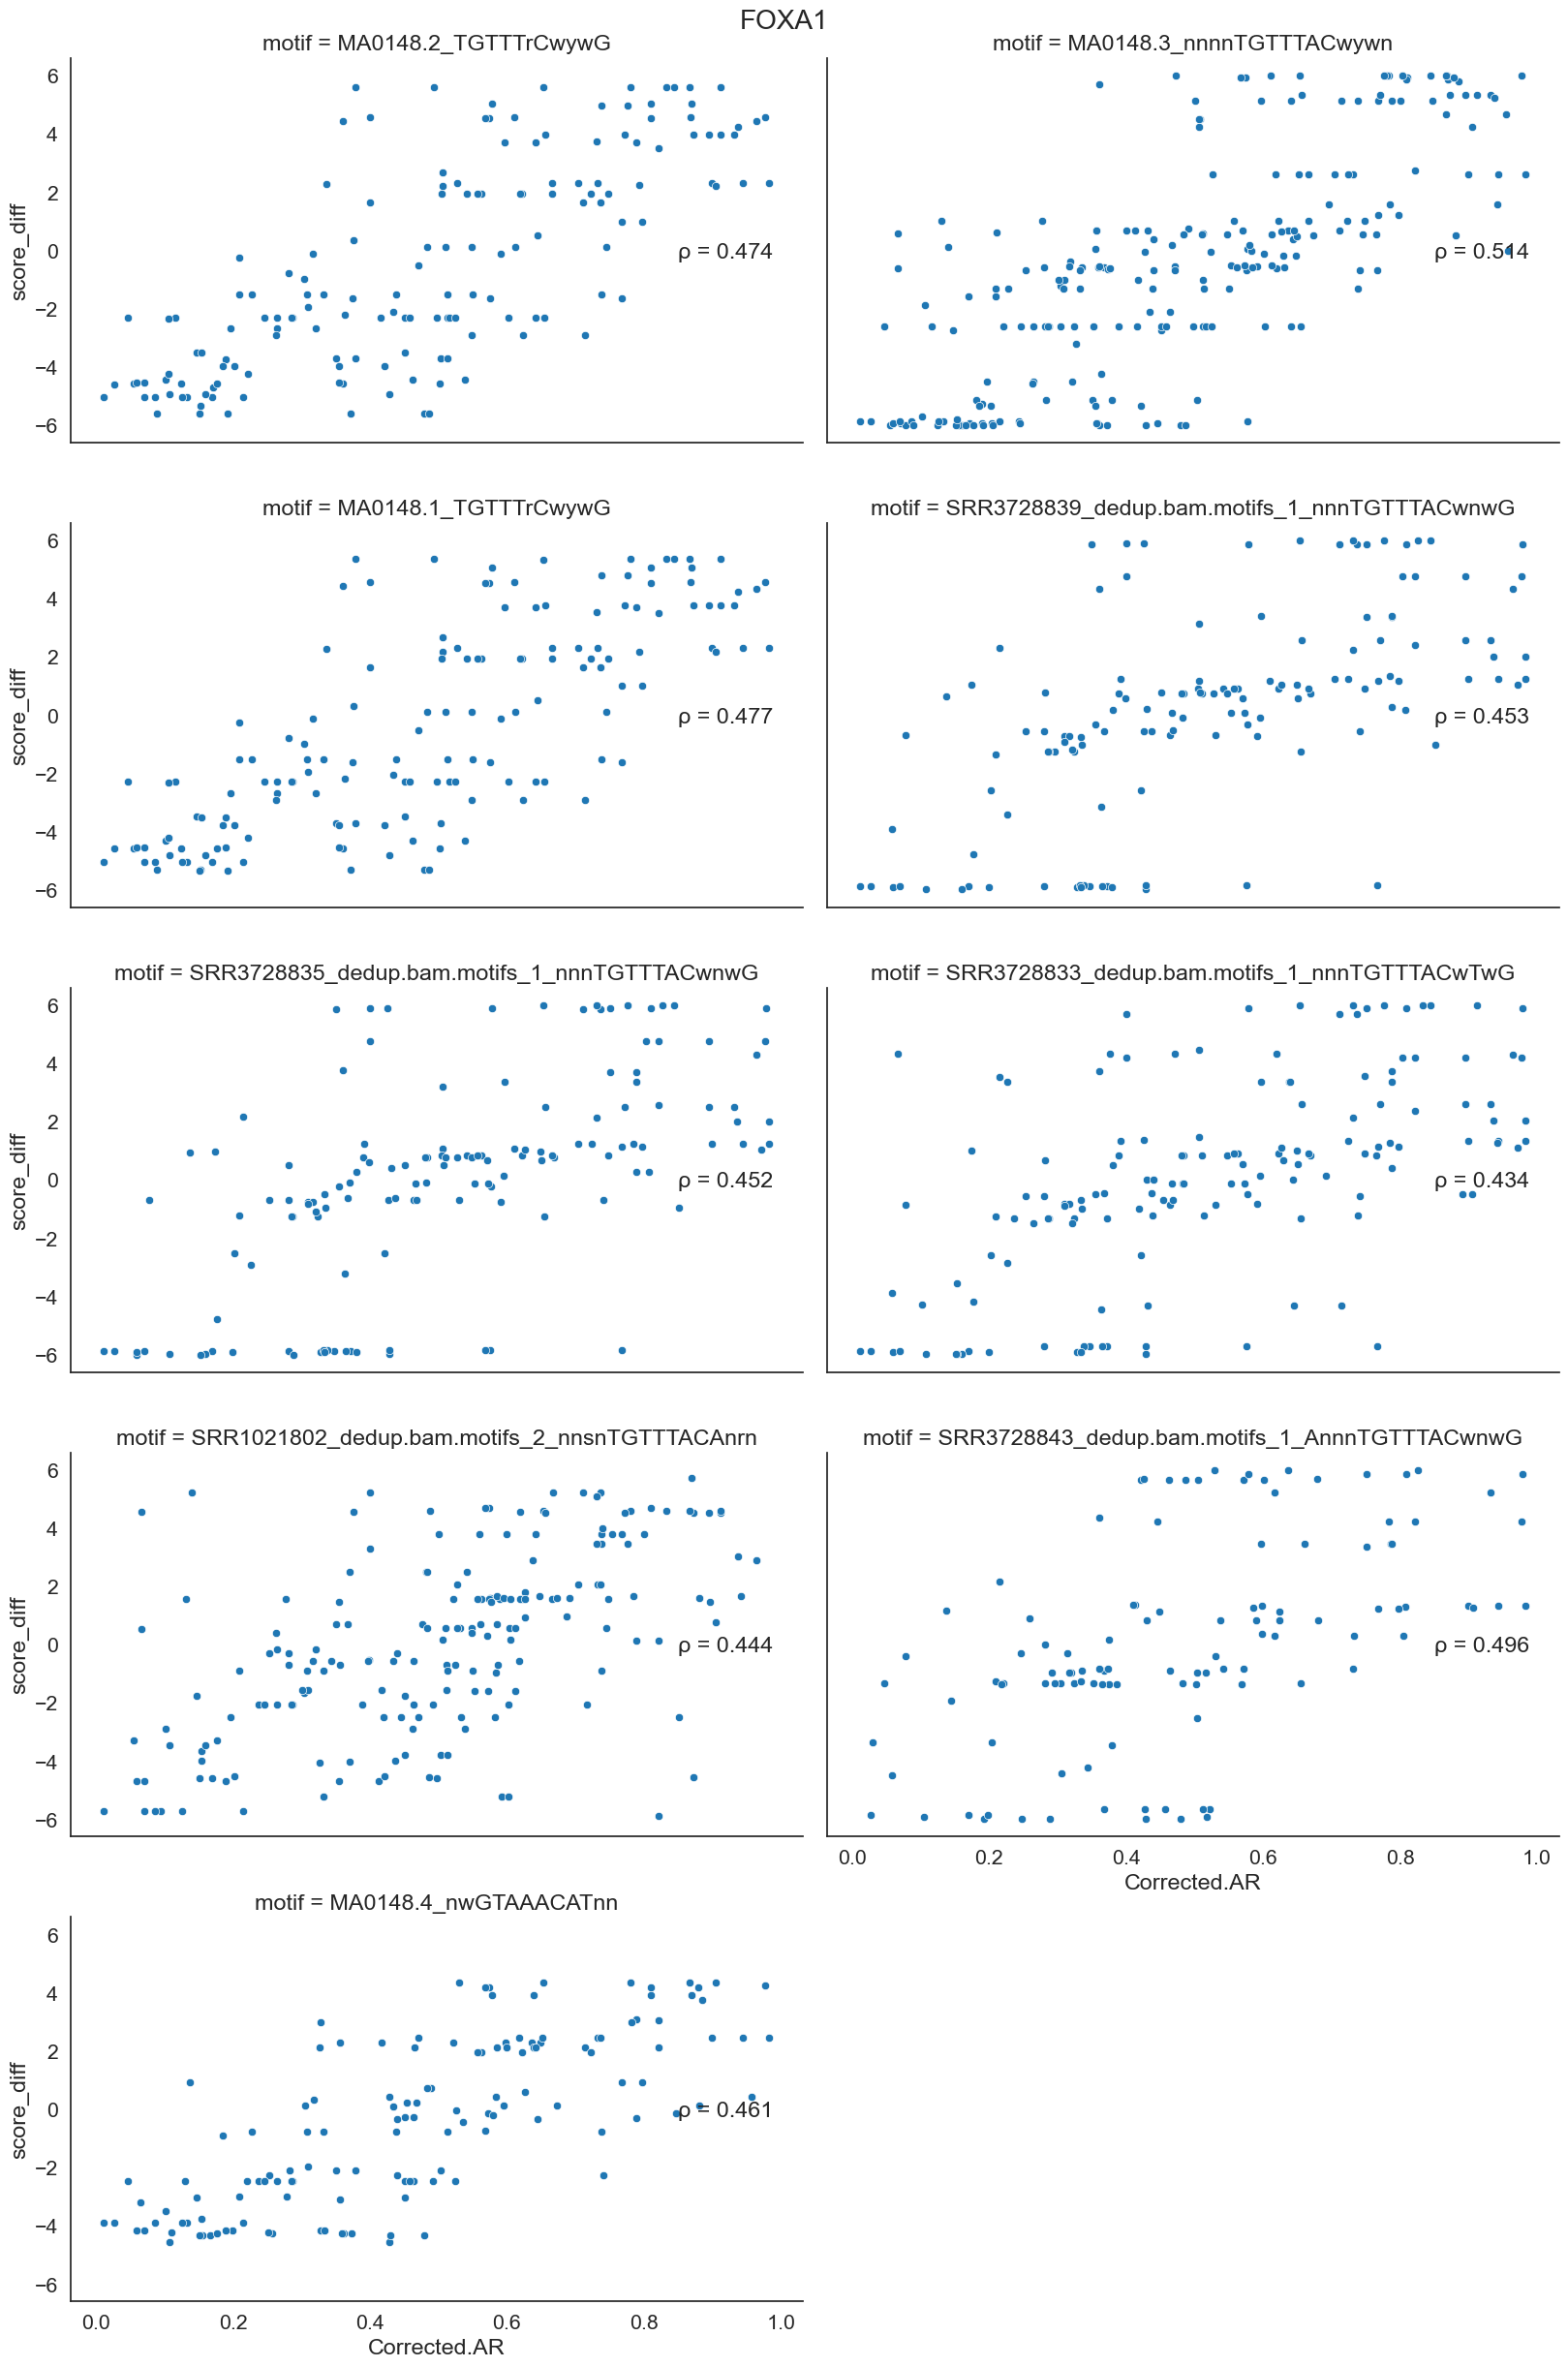

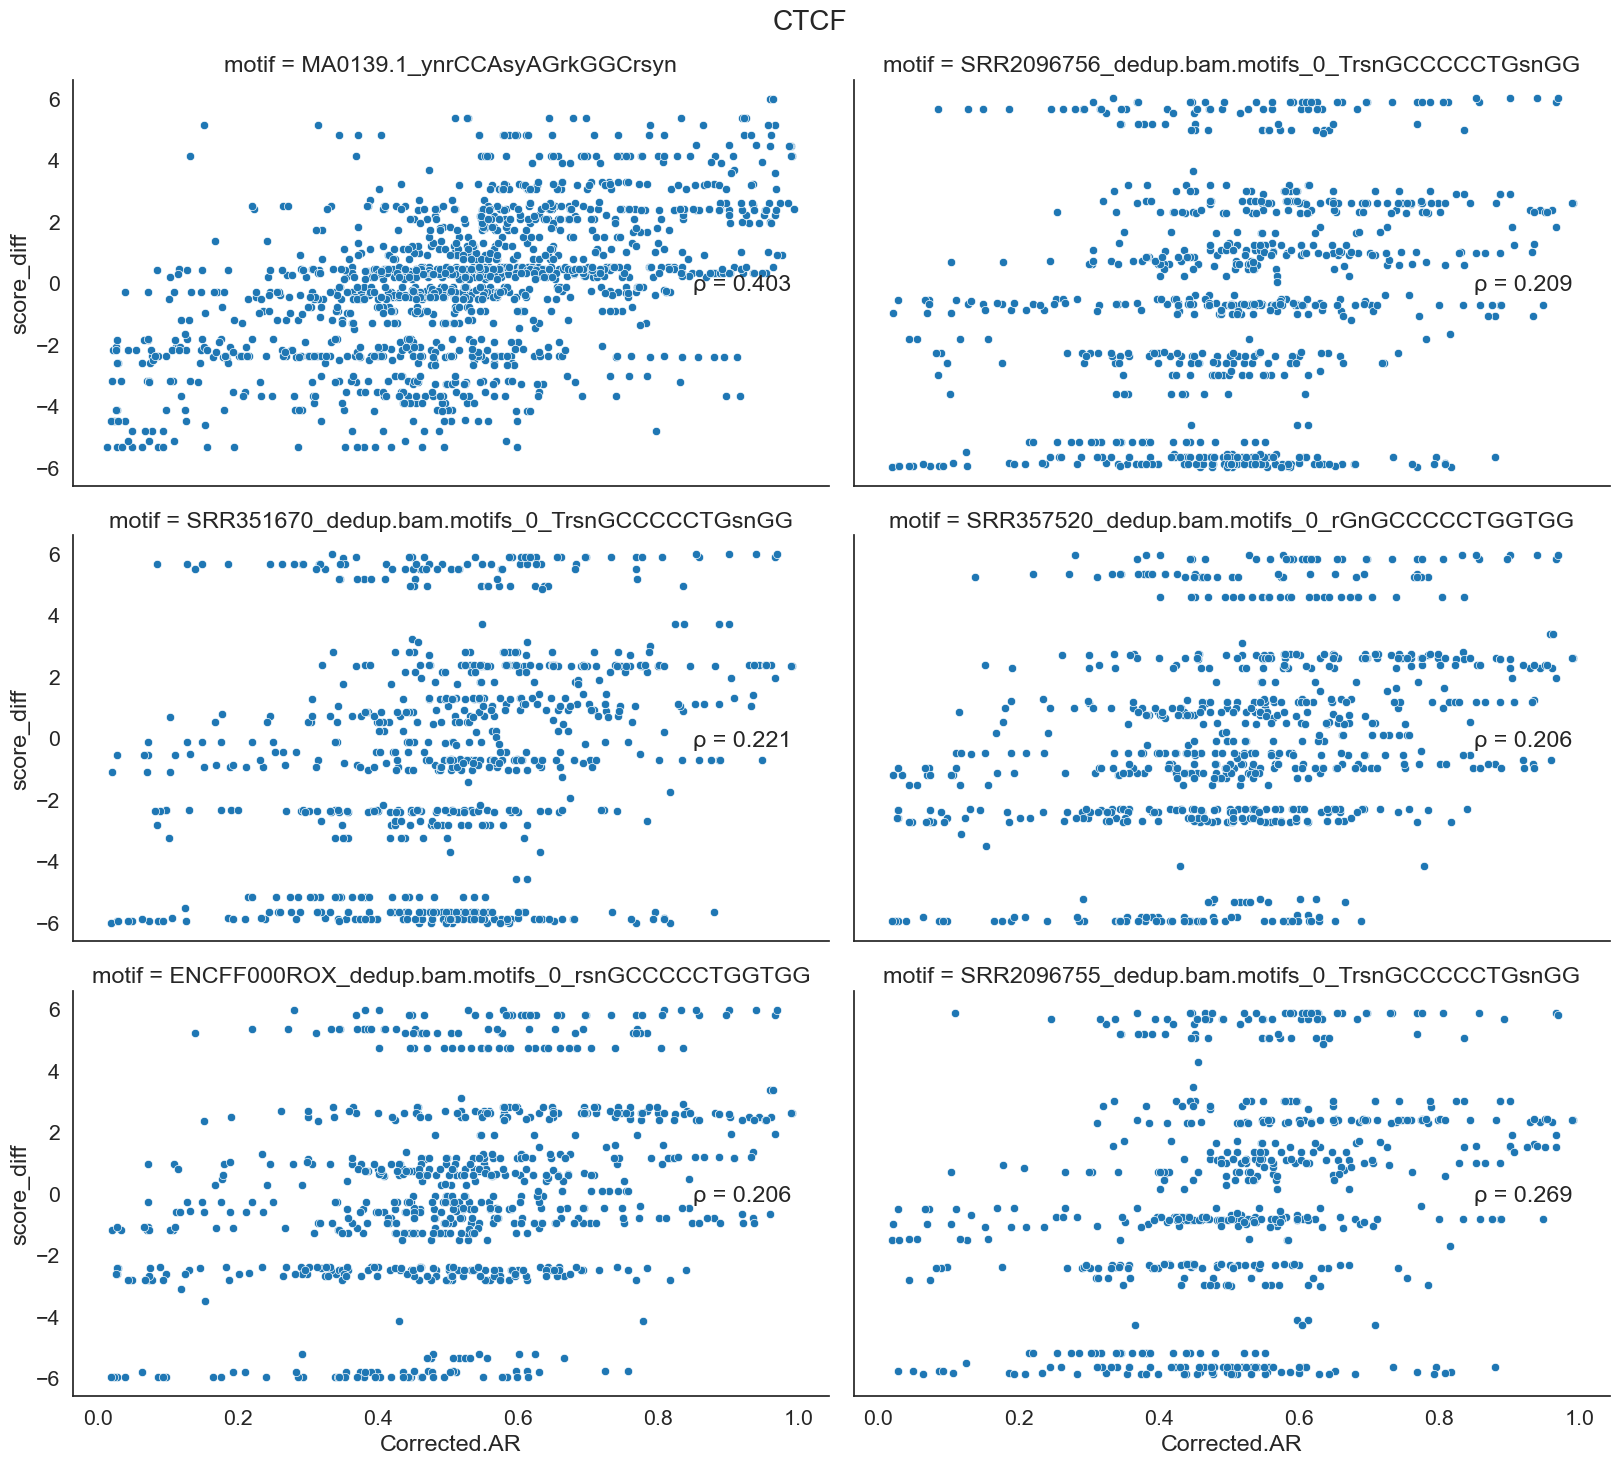

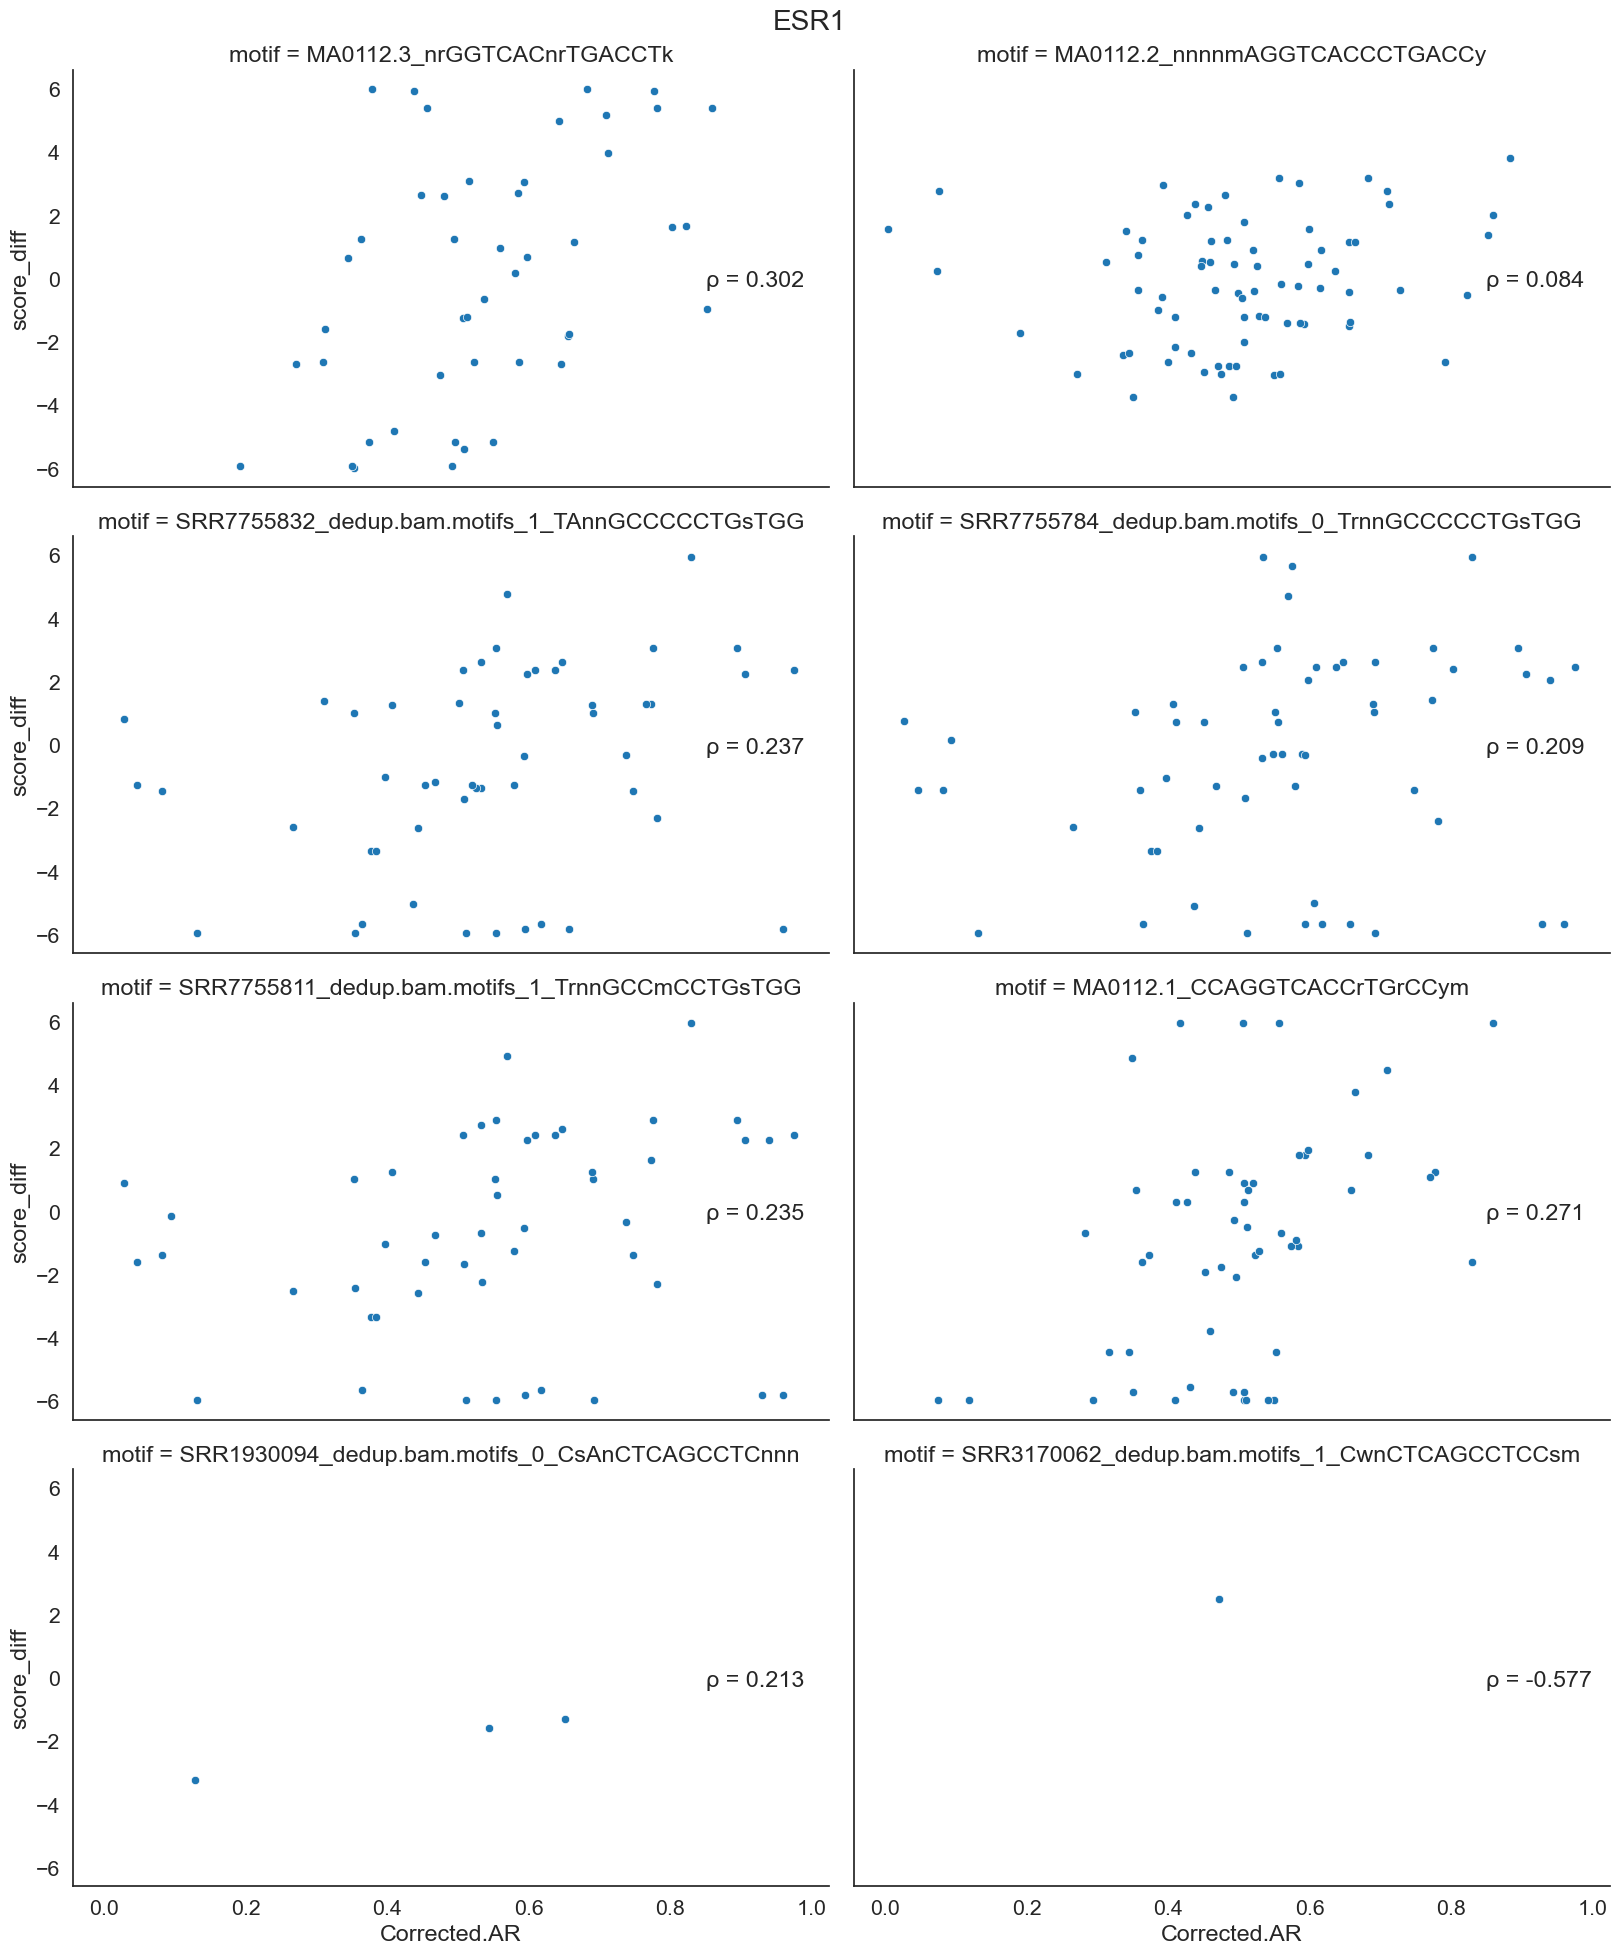

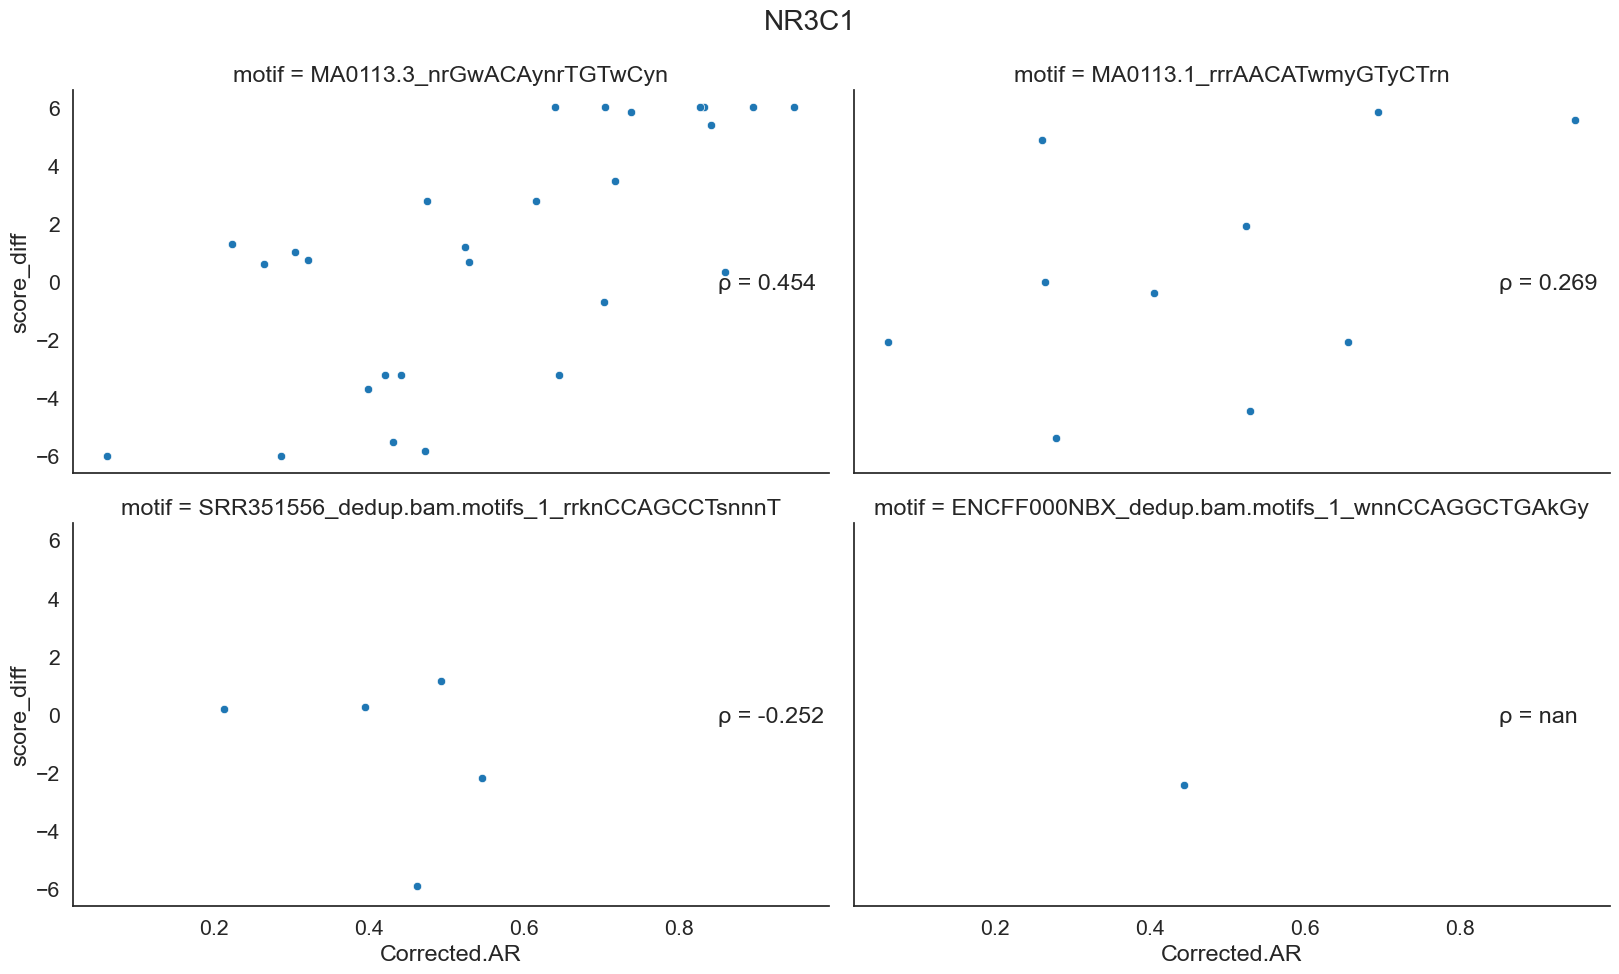

In [12]:
with sns.plotting_context(
    "notebook", font_scale=1.4, rc={"figure.dpi": 300, "savefig.dpi": 300}
):
    for factor, score_set in scores.items():
        plot_data = score_set[round(score_set.score_diff, 6) != 0.0]
        col_order = plot_data.motif.unique()
        g = sns.FacetGrid(
            plot_data,
            col="motif",
            height=5,
            aspect=1.65,
            col_wrap=2,
            col_order=col_order,
        )
        g.map(sns.scatterplot, "Corrected.AR", "score_diff")

        for ax, motif in zip(g.axes.flat, col_order):
            corr = round(correlations[factor][motif], 3)
            ax.text(0.85, -0.25, f"ρ = {corr}")

        g.fig.subplots_adjust(top=0.95)
        g.fig.suptitle(factor)
        plt.tight_layout()

In [13]:
snp_counts = []
for factor, score_set in scores.items():
    id_counts = (
        pd.DataFrame(
            score_set.pivot(columns=("motif"), values=("ID")).apply(
                lambda series: len(series.dropna().unique()), axis=0
            ),
            columns=["counts"],
        )
        .sort_values(by="counts", ascending=False)
        .reset_index()
    )
    id_counts["fraction_of_snps"] = id_counts["counts"] / rsid_counts[factor]
    id_counts["tf"] = factor
    snp_counts.append(id_counts)

snp_counts = pd.concat(snp_counts)
snp_counts.head()

,motif,counts,fraction_of_snps,tf
0,MA0148.2_TGTTTrCwywG,433,0.055691,FOXA1
1,MA0148.3_nnnnTGTTTACwywn,430,0.055305,FOXA1
2,MA0148.1_TGTTTrCwywG,428,0.055048,FOXA1
3,MA0148.4_nwGTAAACATnn,367,0.047203,FOXA1
4,SRR1021802_dedup.bam.motifs_2_nnsnTGTTTACAnrn,356,0.045788,FOXA1


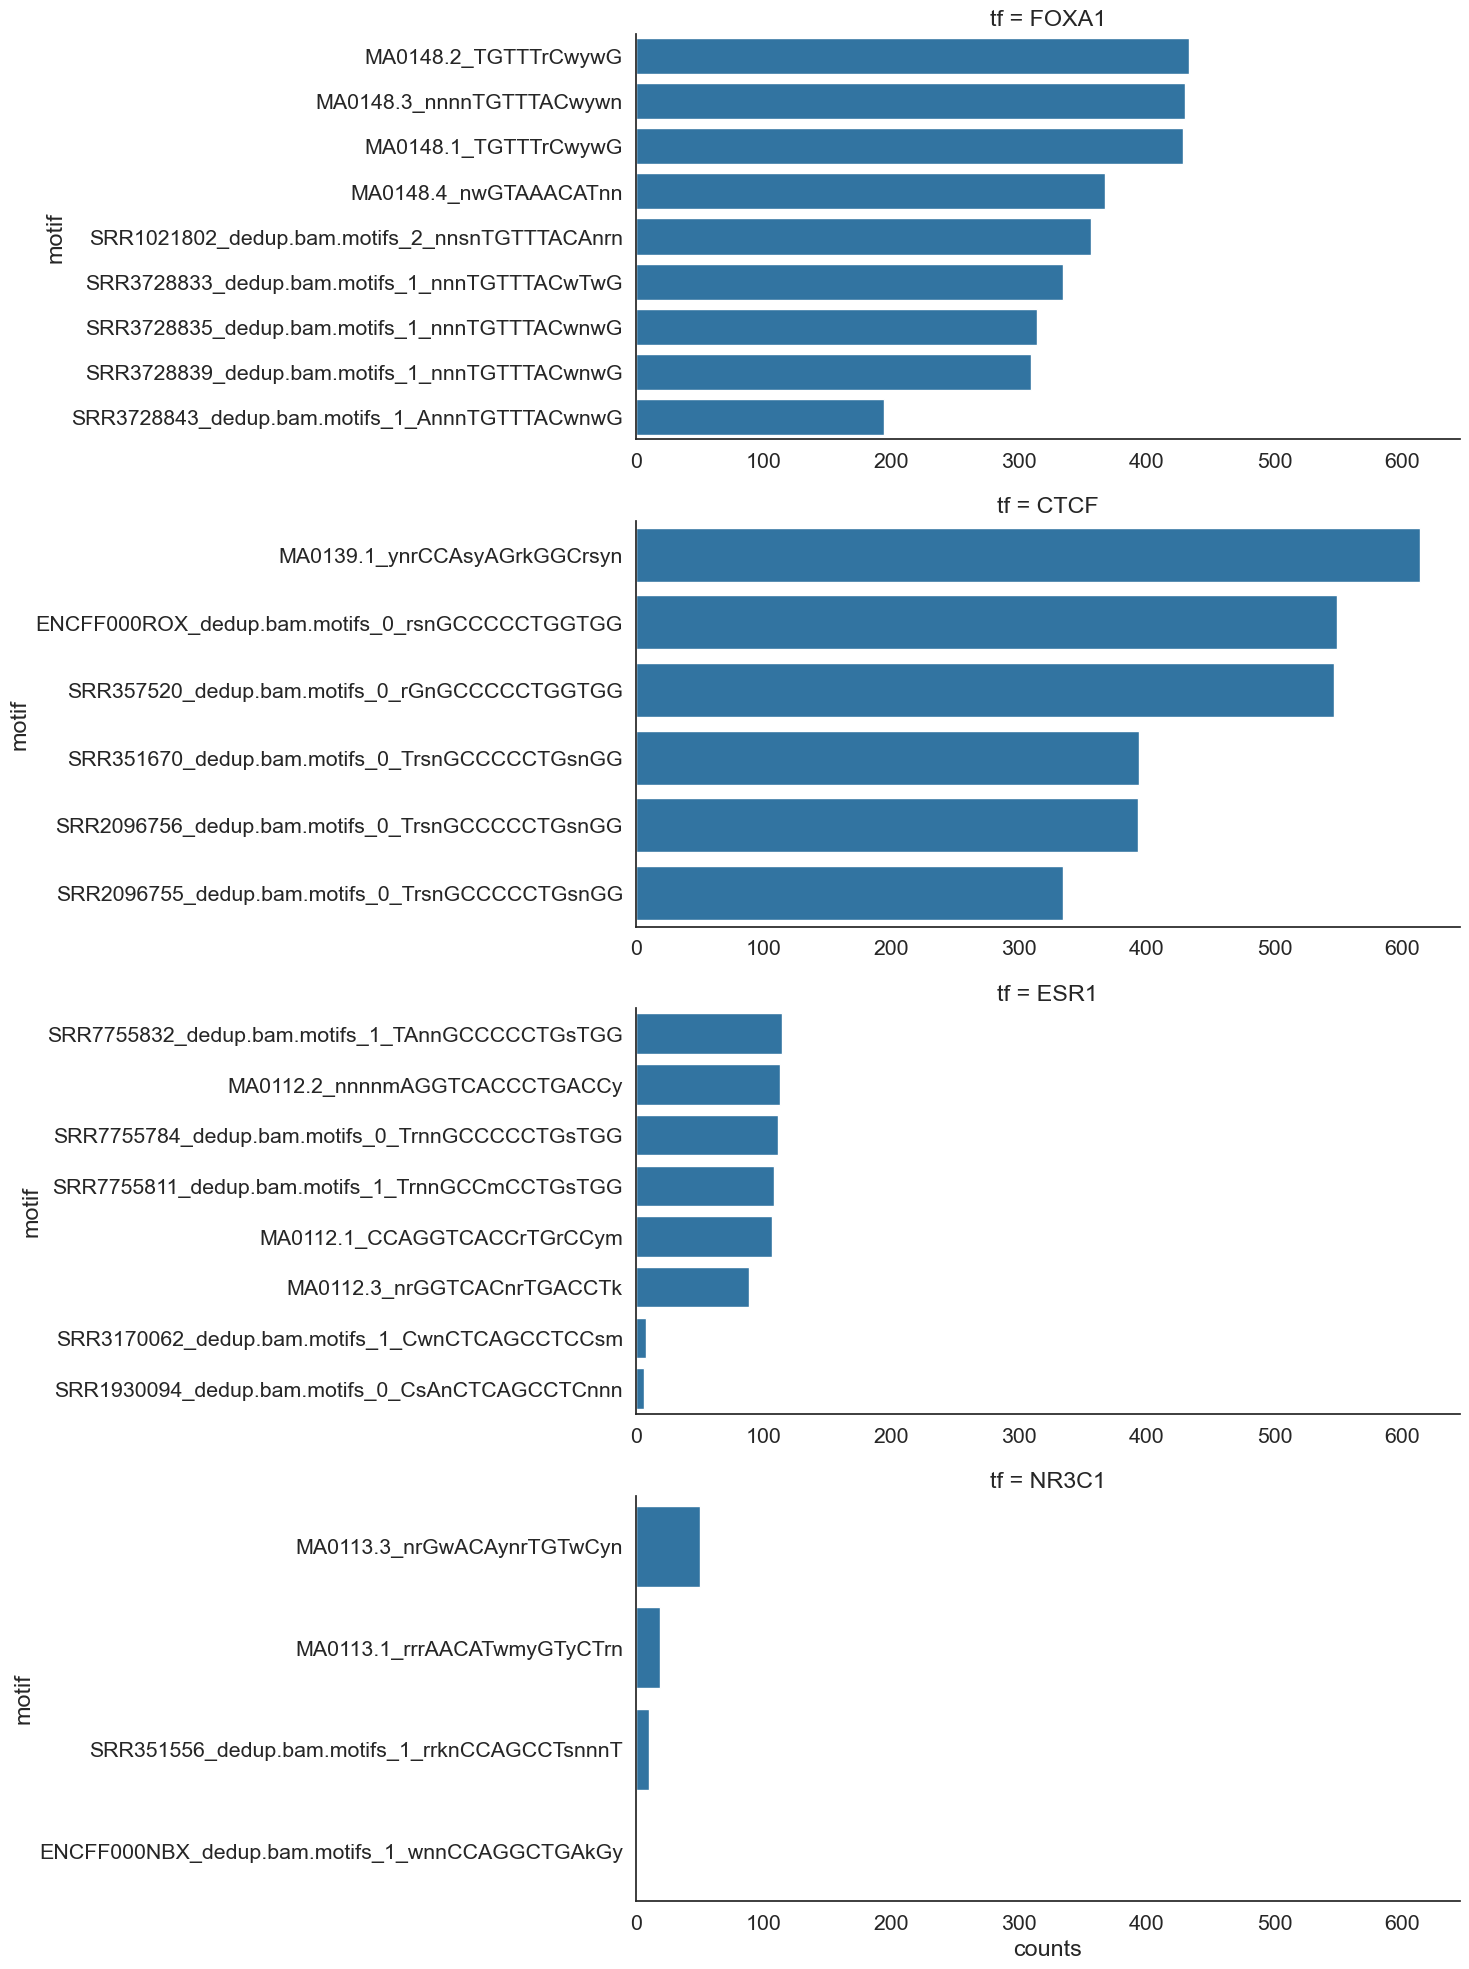

In [14]:
with sns.plotting_context(
    "notebook", font_scale=1.4, rc={"figure.dpi": 500, "savefig.dpi": 300}
):
    g = sns.FacetGrid(
        snp_counts, sharex=True, sharey=False, row="tf", height=5, aspect=3
    )
    g.map(sns.barplot, "counts", "motif")

    for axis in g.axes.flat:
        axis.tick_params(labelbottom=True)

    plt.tight_layout()

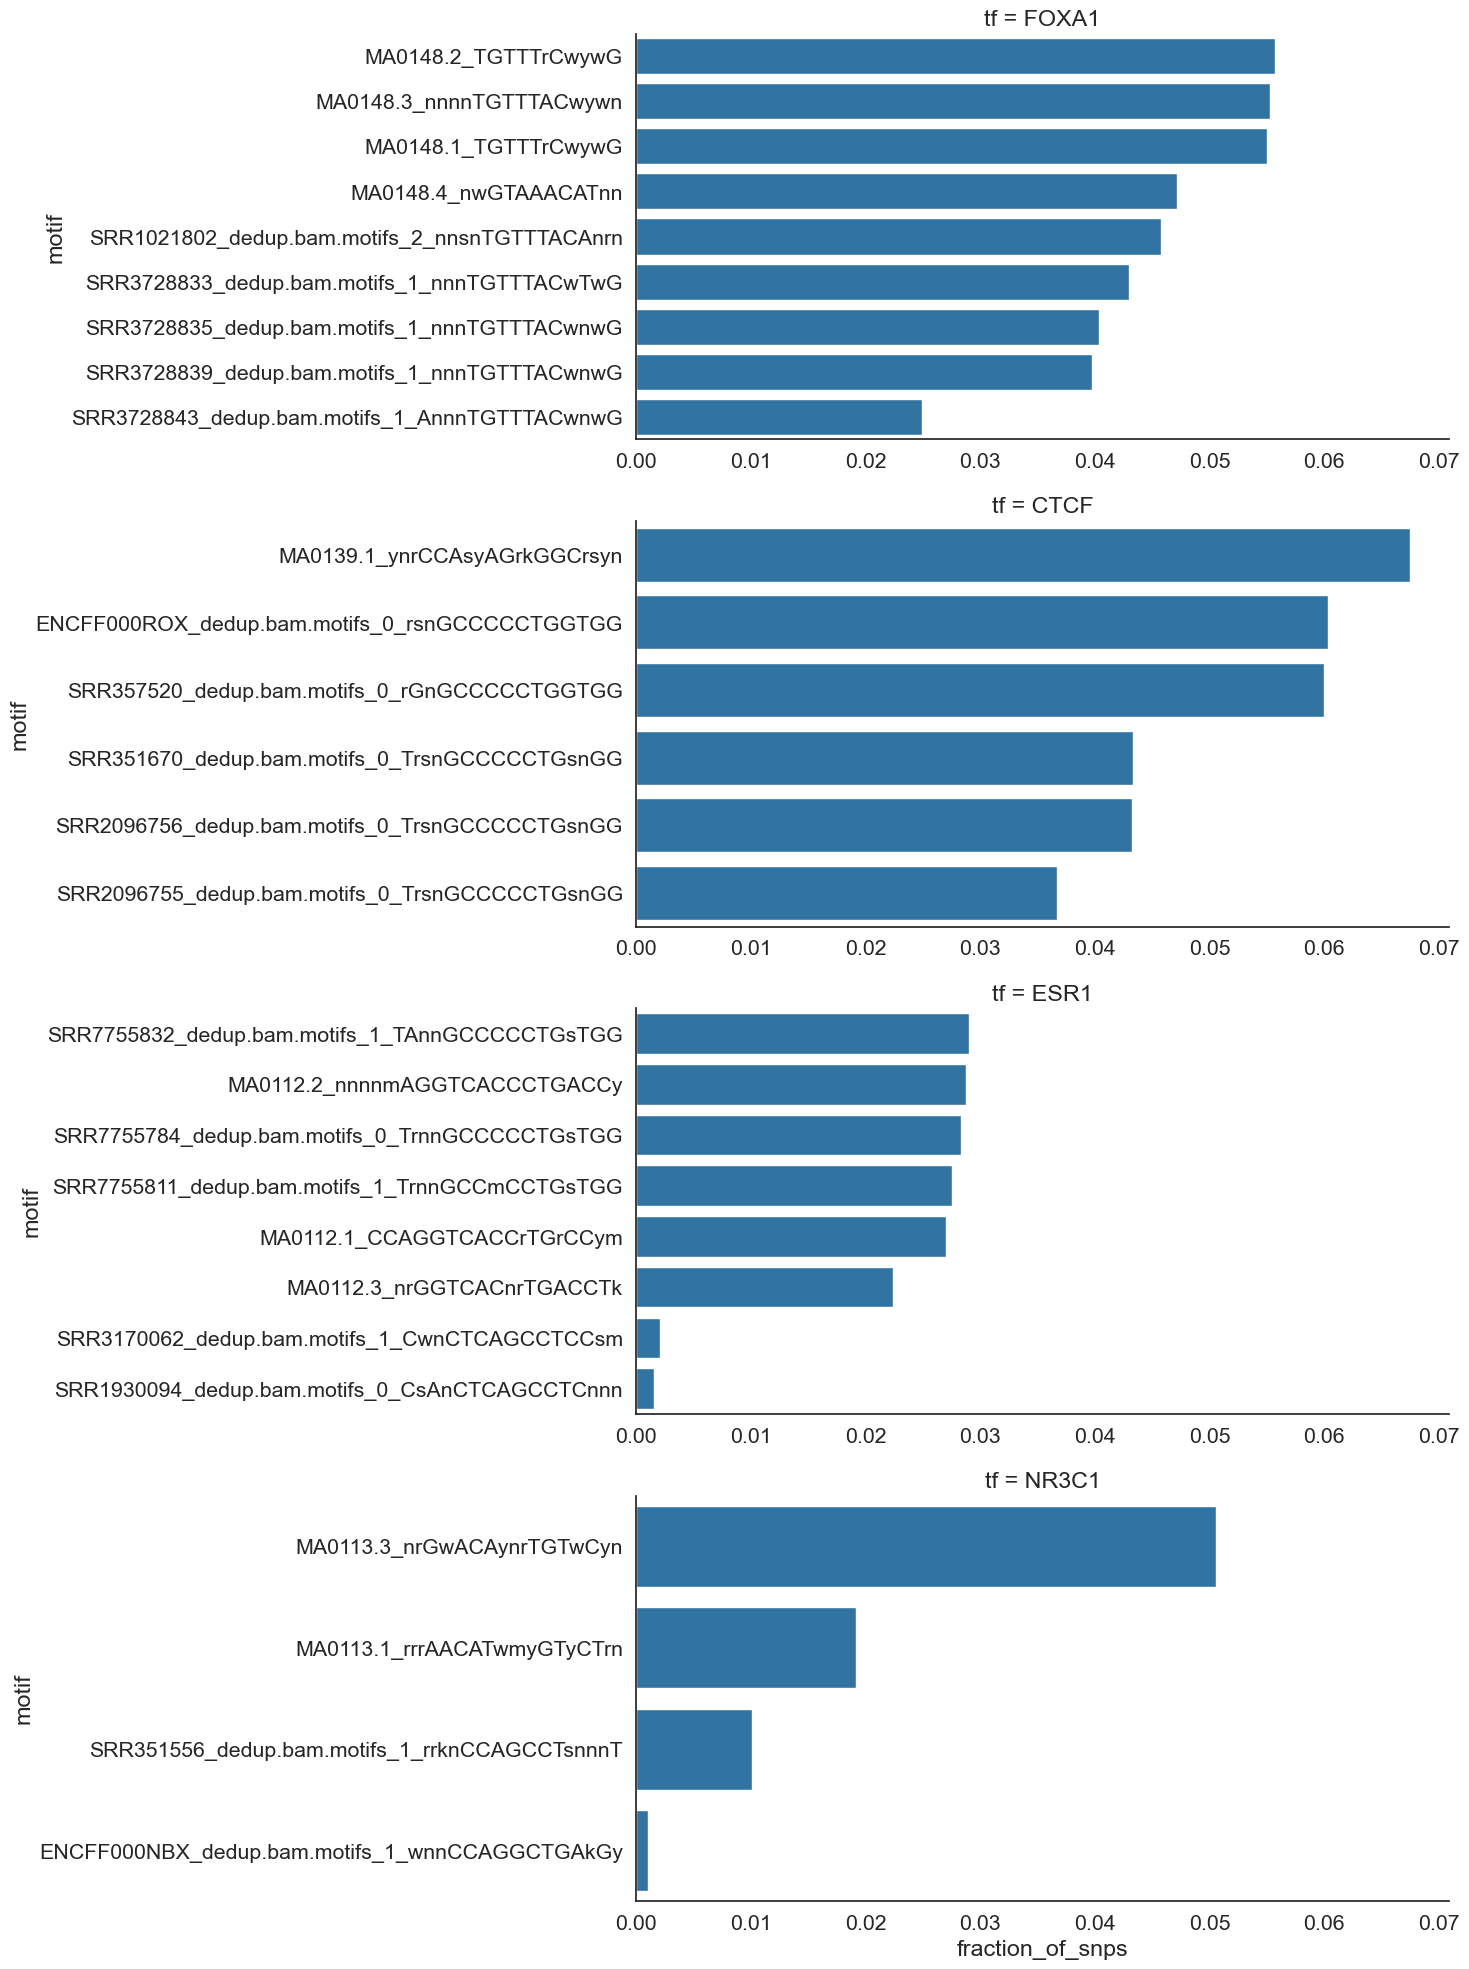

In [15]:
with sns.plotting_context(
    "notebook", font_scale=1.4, rc={"figure.dpi": 500, "savefig.dpi": 300}
):
    g = sns.FacetGrid(
        snp_counts, sharex=True, sharey=False, row="tf", height=5, aspect=3
    )
    g.map(sns.barplot, "fraction_of_snps", "motif")

    for axis in g.axes.flat:
        axis.tick_params(labelbottom=True)

    plt.tight_layout()

# Summary statistics for Chris

In [16]:
def filter_bqtls(df):
    return df[
        df.isASB
        & (
            ((df["Corrected.AR"] > 0.5) & (df.score_diff > 0))
            | ((df["Corrected.AR"] < 0.5) & (df.score_diff < 0))
        )
    ].copy()

In [17]:
for factor, group in asb_data.groupby("tf"):
    total_snps = len(group.ID.unique())
    asb_set = group[group.isASB]
    asb_snps = len(asb_set.ID.unique())
    print(f"factor: {factor}, total SNPs: {total_snps}, bQTLs: {asb_snps}")

factor: CTCF, total SNPs: 9097, bQTLs: 1889
factor: ESR1, total SNPs: 3923, bQTLs: 962
factor: FOXA1, total SNPs: 7775, bQTLs: 1680
factor: NR3C1, total SNPs: 989, bQTLs: 95


In [18]:
for factor, group in scores.items():
    total_snps = len(group.ID.unique())
    filtered = filter_bqtls(group)
    filtered_bqtls = len(filtered.ID.unique())
    print(
        f"factor: {factor}, Significant SNPs: {total_snps}, Filtered bQTLs: {filtered_bqtls}"
    )

factor: FOXA1, Significant SNPs: 960, Filtered bQTLs: 158
factor: CTCF, Significant SNPs: 1029, Filtered bQTLs: 208
factor: ESR1, Significant SNPs: 333, Filtered bQTLs: 46
factor: NR3C1, Significant SNPs: 72, Filtered bQTLs: 9


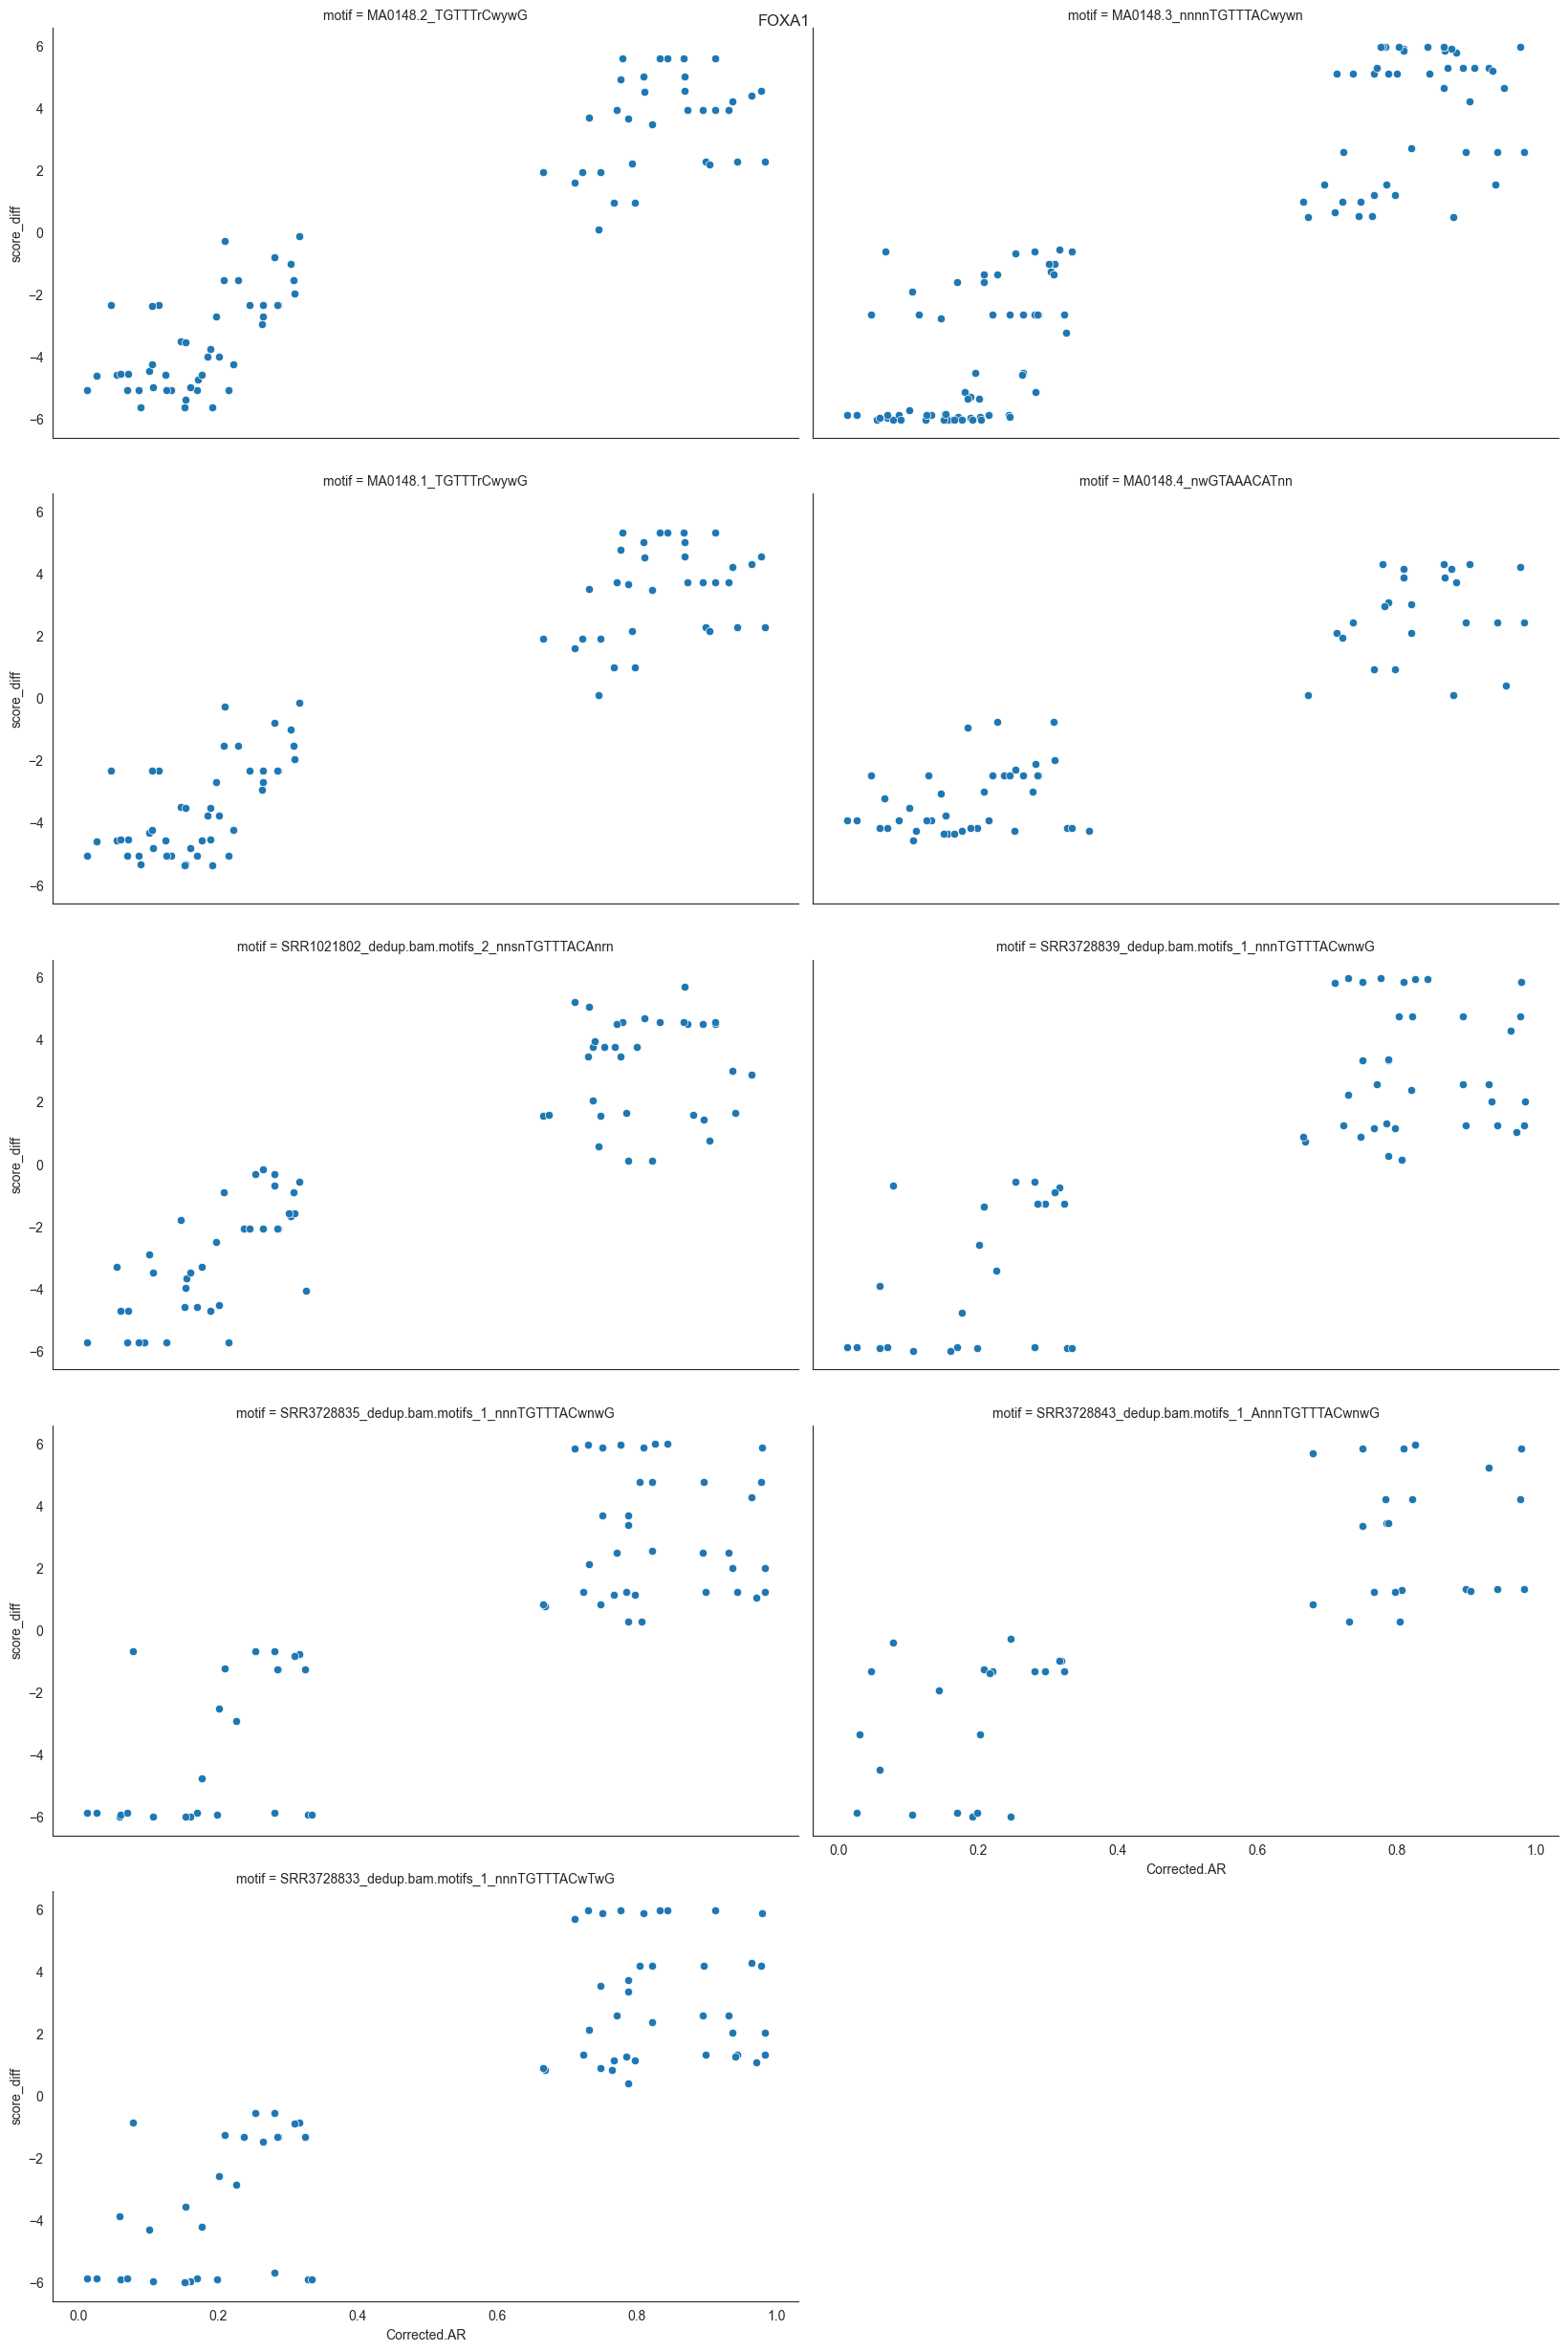

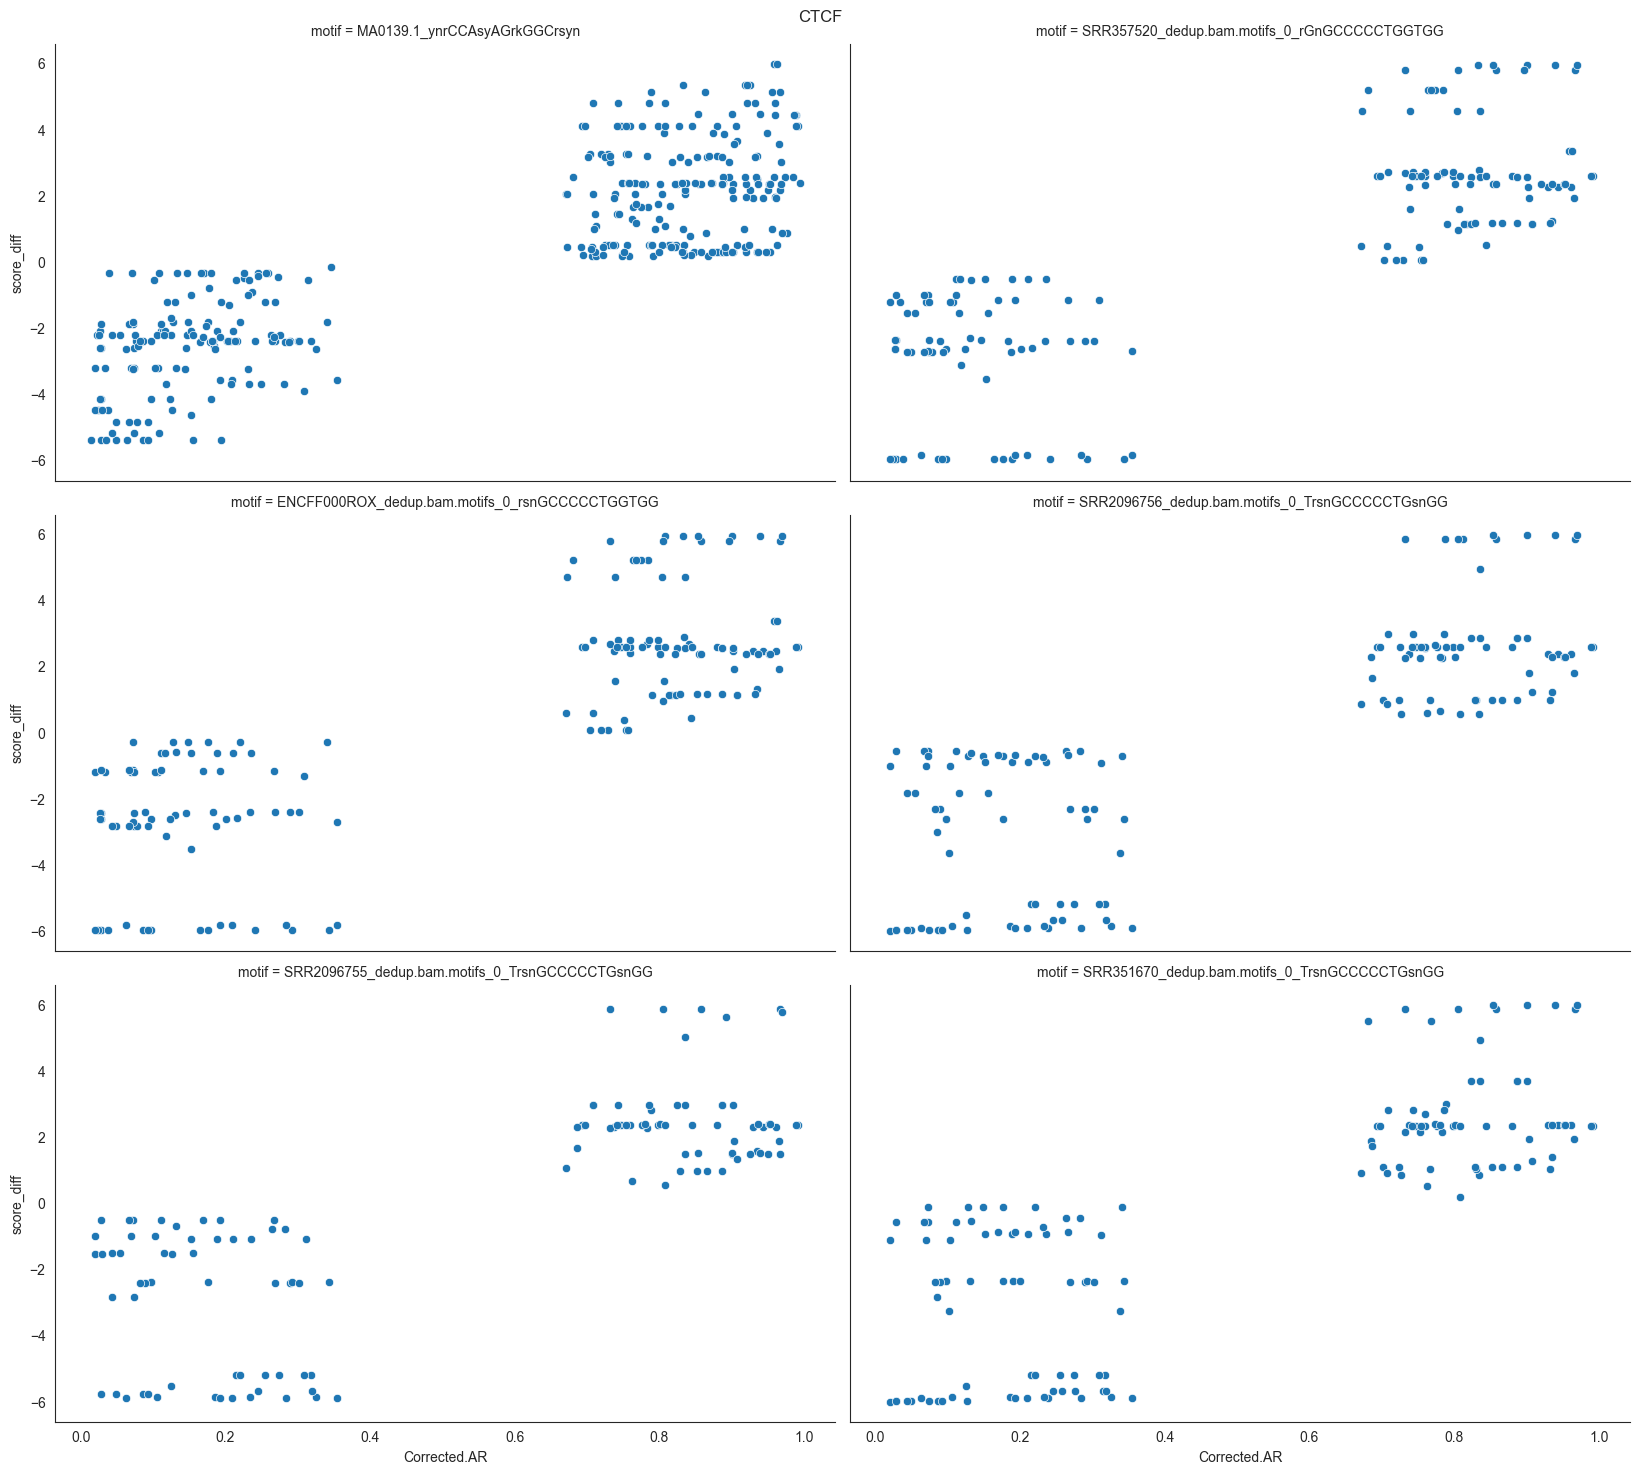

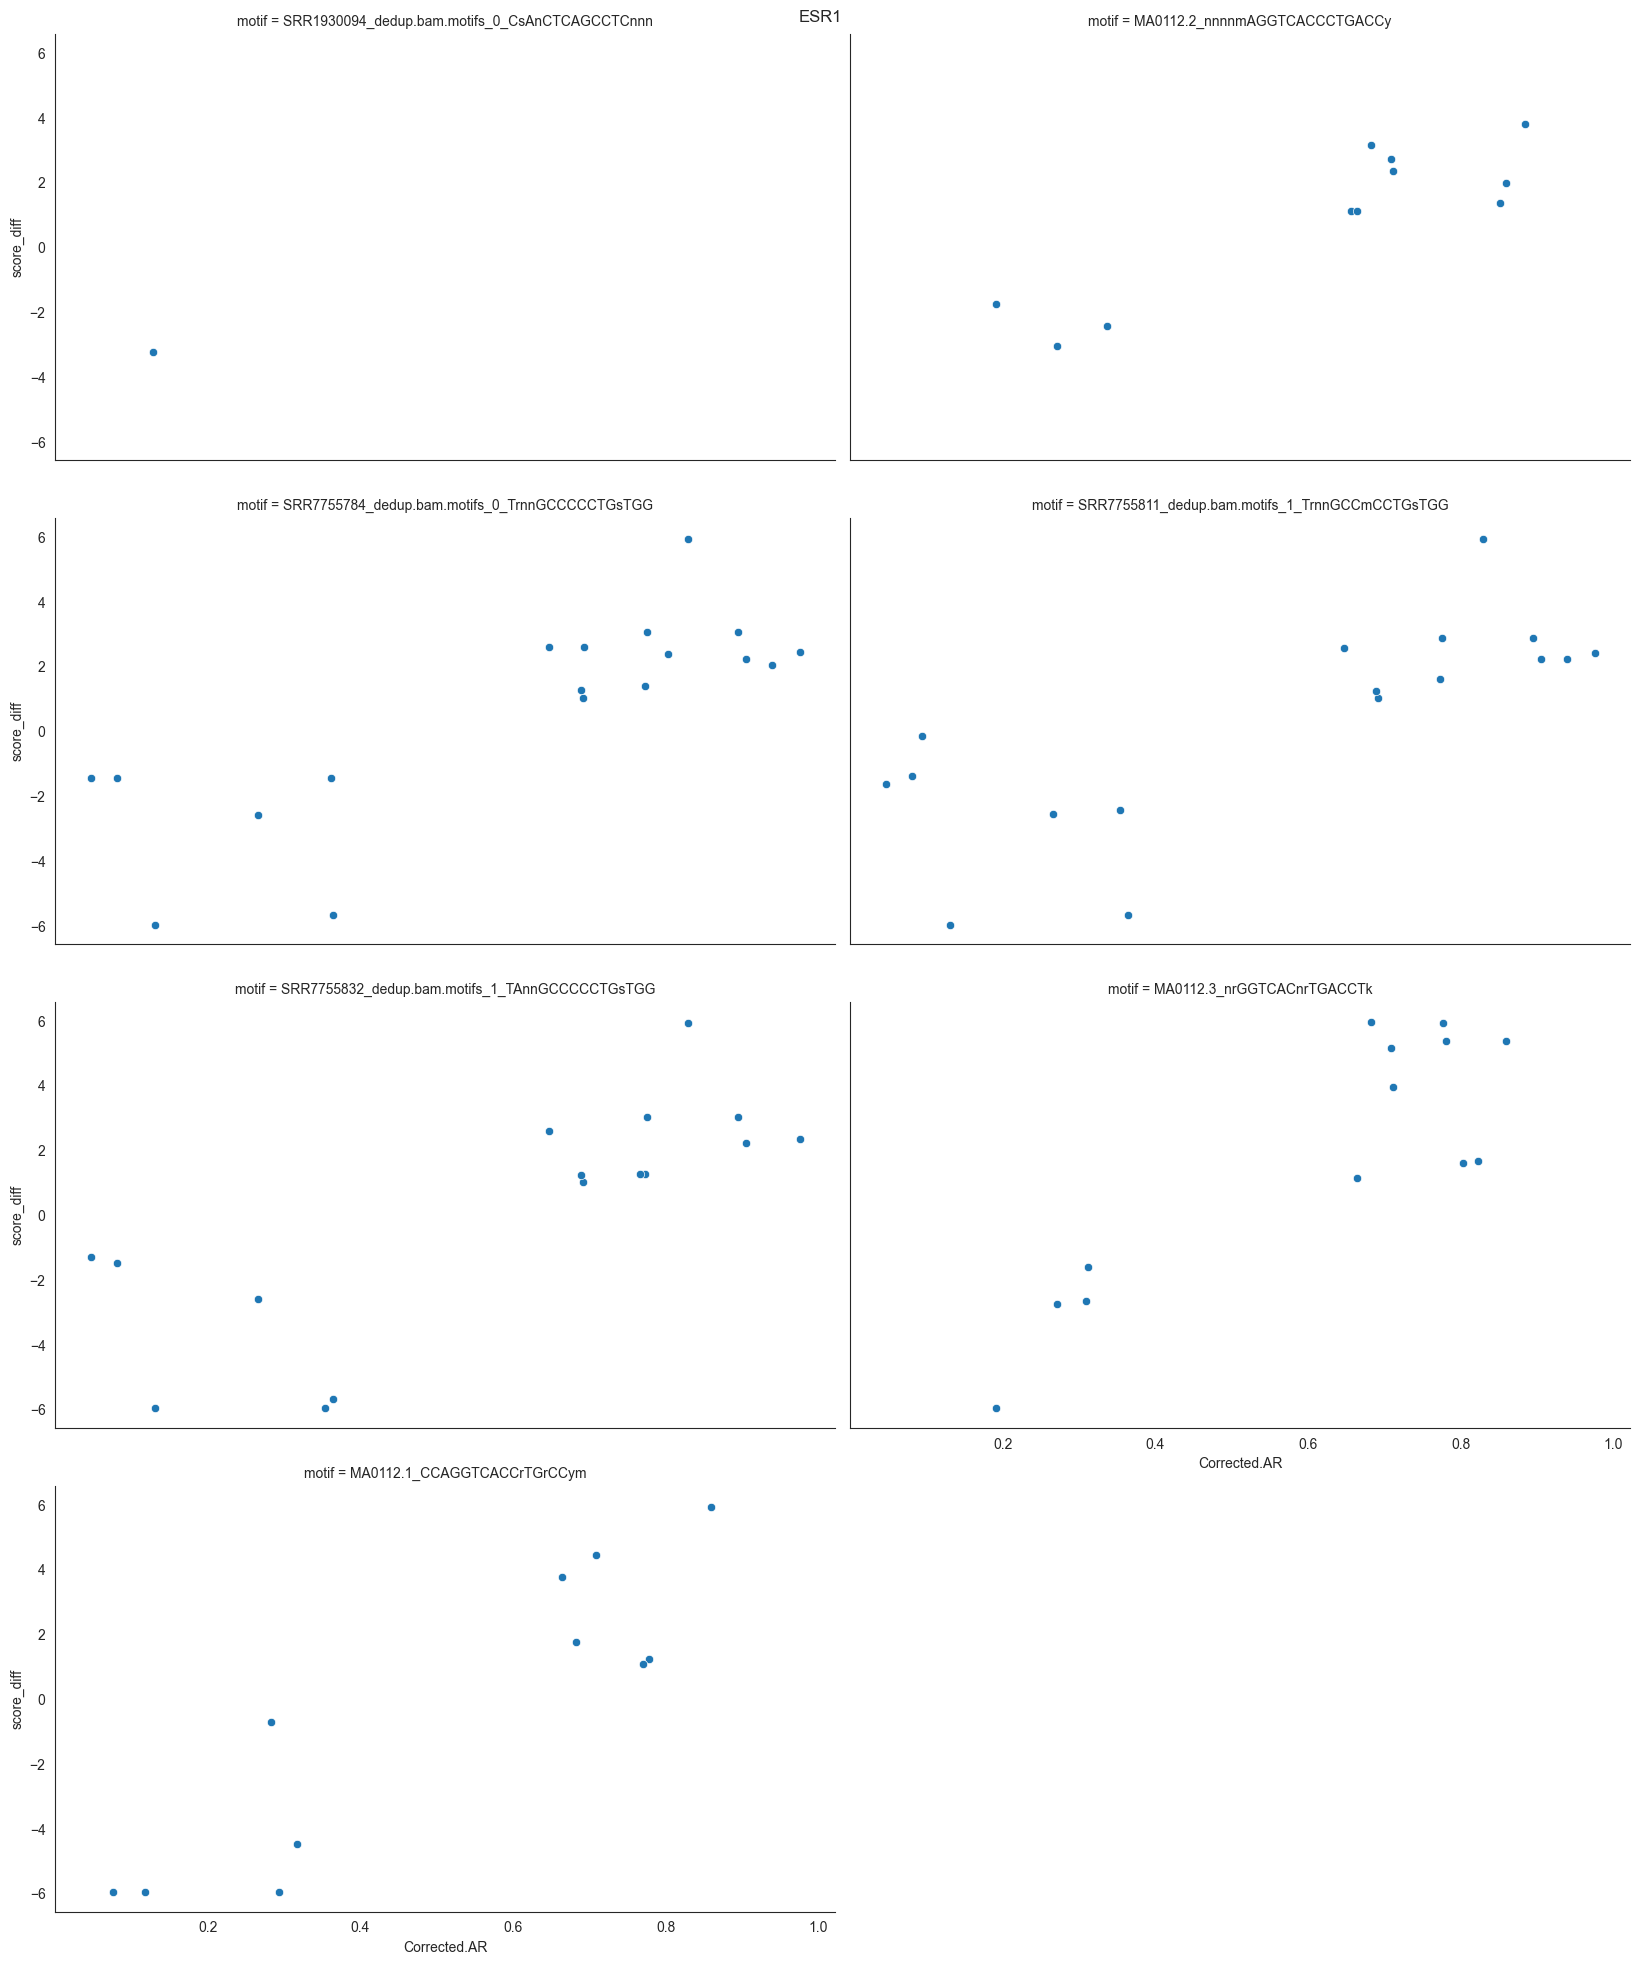

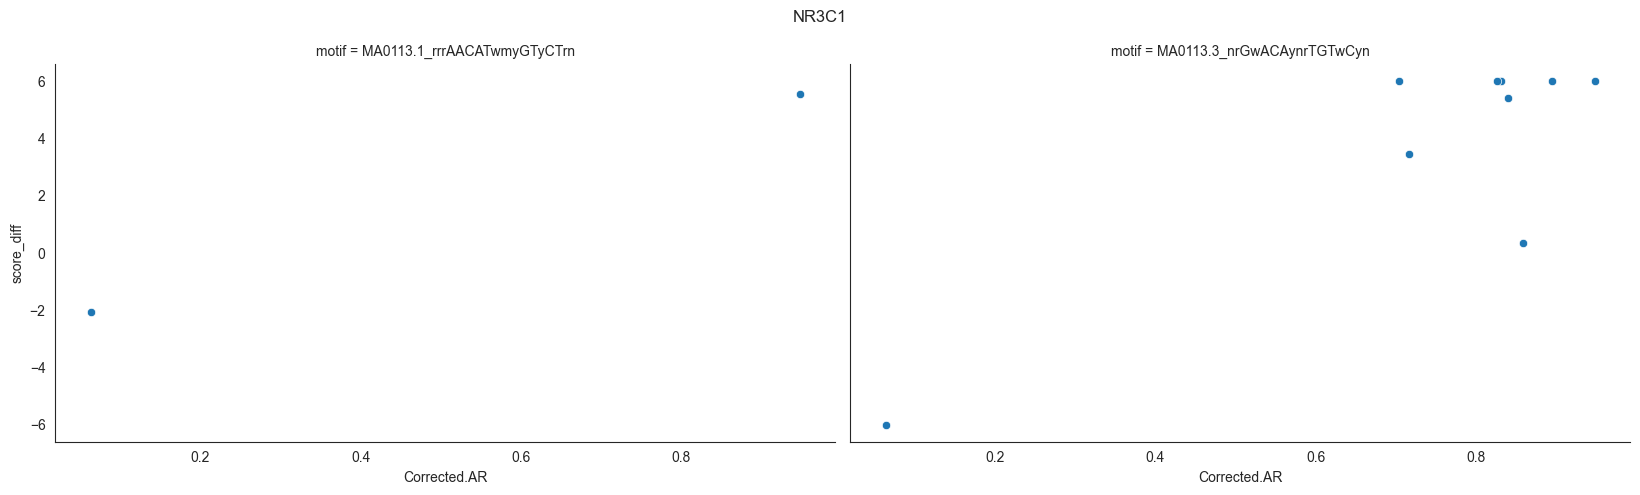

In [19]:
for factor, group in scores.items():
    plot_data = filter_bqtls(group)
    col_order = plot_data.motif.unique()
    g = sns.FacetGrid(
        plot_data, col="motif", height=5, aspect=1.65, col_wrap=2, col_order=col_order
    )
    g.map(sns.scatterplot, "Corrected.AR", "score_diff")
    g.fig.subplots_adjust(top=0.95)
    g.fig.suptitle(factor)
    plt.tight_layout()